In [136]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, explained_variance_score
from side_info_decoding.utils import load_data_from_pids

In [52]:
def sliding_window_over_time(data, window_size=10):
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - window_size, window_size
        ))
        for t in range(window_size, n_t_bins):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t - d]
            data_window[:,:,t-window_size] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        data_window = np.zeros((n_trials, n_t_bins - window_size))
        for t in range(window_size, n_t_bins):
            data_window[:,t-window_size] = data[:,t]
    return data_window

In [115]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    '31f3e083-a324-4b88-b0a4-7788ec37b191',
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "41a3b948-13f4-4be7-90b9-150705d39005",
    "63517fd4-ece1-49eb-9259-371dc30b1dd6",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf"
]

In [143]:
save_dir = Path("/home/yizi/side_info_decoding/saved_results/lightning_pose_res_bkp/")
behavior_type = "pupil_diameter"

In [144]:
baseline_metrics, rrr_metrics = [], []
for pid in pids:
    save_path = save_dir/pid/f"{behavior_type}"
    metrics = np.load(save_path/"metrics.npy", allow_pickle=True).item()[pid]
    baseline_metrics.append(metrics["baseline"])
    rrr_metrics.append(metrics["rrr"])
baseline_metrics = np.array(baseline_metrics)
rrr_metrics = np.array(rrr_metrics)

In [145]:
print(baseline_metrics.mean((0,1))[0])
print(rrr_metrics.mean((0,1))[0])

0.1567531624693164
0.24124580800129


In [146]:
print((0.24124580800129 - 0.1567531624693164)/0.24124580800129)

0.35023466824974553


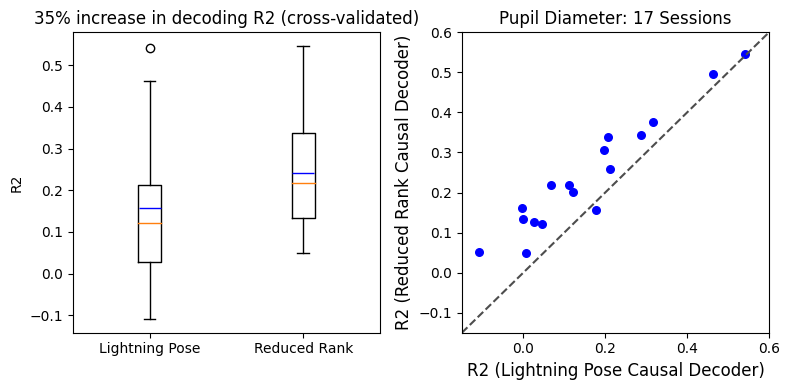

In [160]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.boxplot(
    np.c_[baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0]], 
    showmeans=True, 
    vert=True, patch_artist=False, labels=["Lightning Pose", "Reduced Rank"],
    meanprops={'marker':'_',
               'markerfacecolor':'white', 
               'markeredgecolor':'b',
               'markersize':'16'},
)
ax1.set_ylabel("R2")
ax1.set_title("35% increase in decoding R2 (cross-validated)")

ax2.scatter(baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0], c="blue", s=30)
ax2.set_xlim(-0.15, 0.6)
ax2.set_ylim(-0.15, 0.6)
ax2.set_xlabel("R2 (Lightning Pose Causal Decoder)", fontsize=12)
ax2.set_ylabel("R2 (Reduced Rank Causal Decoder)", fontsize=12)
ax2.plot([-0.15, 0.6], [-0.15, 0.6], ls="--", c=".3")
ax2.set_title(f"Pupil Diameter: {len(pids)} Sessions")

plt.tight_layout()
plt.savefig("/home/yizi/side_info_decoding/saved_plots/lightning_pose_perf.png",
            dpi = 400)

In [38]:
pid = pids[0]
save_path = save_dir/pid/f"{behavior_type}"
traces = np.load(save_path/"traces.npy", allow_pickle=True).item()[pid]
baseline_traces = traces["baseline"]
rrr_traces = traces["rrr"]

In [ ]:
obs_traces = {}
for pid in pids:
    
    obs_traces[pid] = []
    
    X_dict, Y_dict = load_data_from_pids(
        [pid],
        brain_region="all",
        behavior=behavior_type,
        data_type="all_ks",
        n_t_bins = 60,
        align_time_type="feedback_times",
        t_before=0.2,
        t_after=1.0,
        normalize_input=False
    )
    
    X, Y = X_dict[pid], Y_dict[pid]
    offset = Y.max()
    Y /= offset
    window_Y = sliding_window_over_time(Y, window_size=10)
    
    xval_traces = []
    kf = KFold(n_splits=5, shuffle=True, random_state=666)
    for train, test in kf.split(X, Y):
        xval_traces.append(window_Y[test])
        
    obs_traces[pid].append(xval_traces)

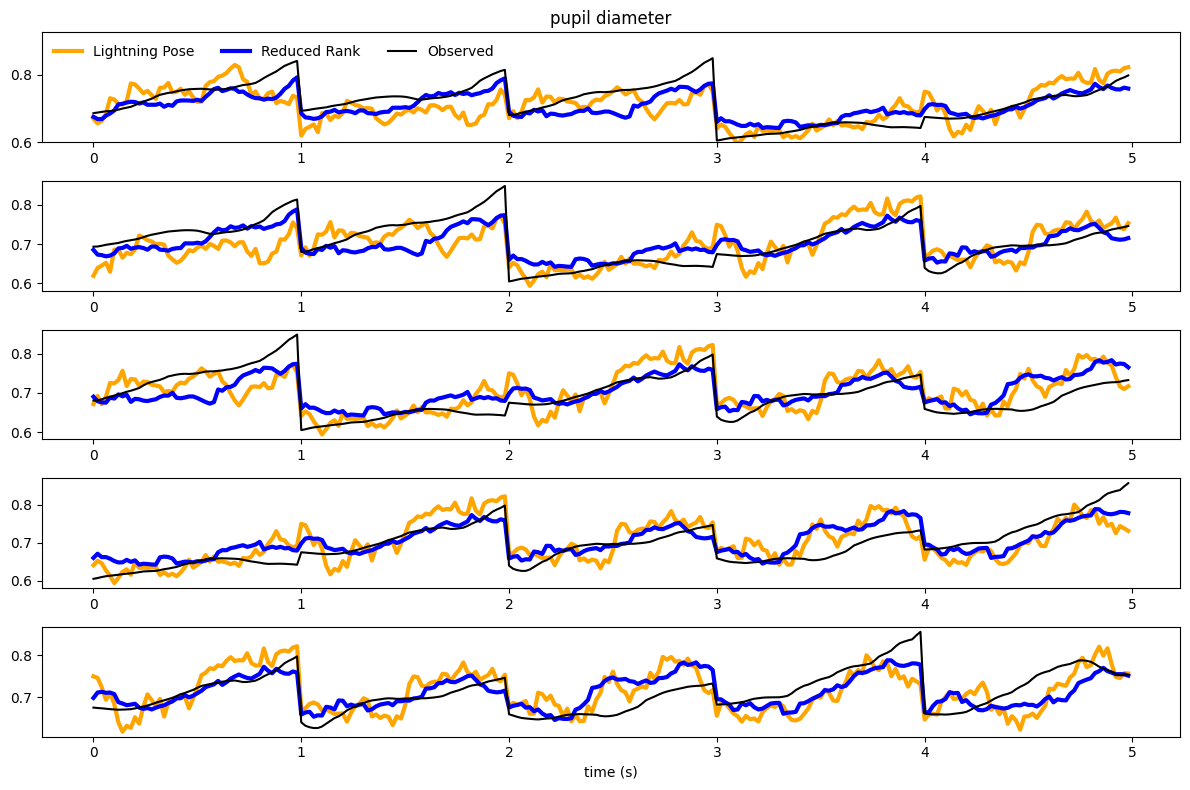

In [99]:
fig, axes = plt.subplots(5,1,figsize=(12,8))
for i, ax in enumerate(axes):
    ax.plot(baseline_traces[-1][i:i+5].flatten(), c="orange", linewidth=3, label="Lightning Pose")
    ax.plot(rrr_traces[-1][i:i+5].flatten(), c="b", linewidth=3, label="Reduced Rank")
    ax.plot(obs_traces[-1][i:i+5].flatten(), c="k", label="Observed")
    ax.set_xticks([0, 50, 100, 150, 200, 250], [0, 1, 2, 3, 4, 5])
    if i == 0:
        ax.set_title("pupil diameter")
        ax.legend(loc="upper left", ncol=3, frameon=False)
        ax.set_ylim(0.6, .925)
ax.set_xlabel("time (s)")
plt.tight_layout()
# plt.savefig("/home/yizi/side_info_decoding/saved_plots/lightning_pose_traces.png",
#             dpi = 400)

#### Plot using adjusted R2`

In [118]:
save_dir = Path("/home/yizi/side_info_decoding/saved_results/lightning_pose_res_bkp/")
behavior_type = "pupil_diameter"

In [139]:
baseline_r2, rrr_r2 = [], []
for pid in pids:
    baseline_xval, rrr_xval = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=666)
    for i, (train, test) in enumerate(kf.split(X, Y)):
        save_path = save_dir/pid/f"{behavior_type}"
        traces = np.load(save_path/"traces.npy", allow_pickle=True).item()[pid]
        baseline_xval.append(explained_variance_score(obs_traces[pid][0][i].flatten(), traces["baseline"][i].flatten()))
        rrr_xval.append(explained_variance_score(obs_traces[pid][0][i].flatten(), traces["rrr"][i].flatten()))
    baseline_r2.append(np.mean(baseline_xval))
    rrr_r2.append(np.mean(rrr_xval))

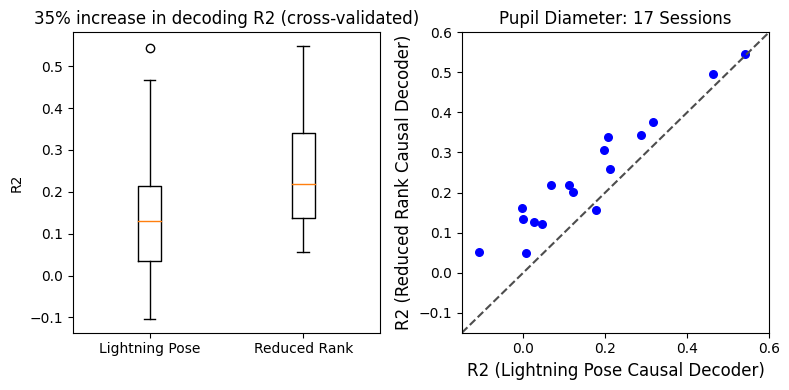

In [140]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.boxplot(
    np.c_[baseline_r2, rrr_r2], 
    vert=True, patch_artist=False, labels=["Lightning Pose", "Reduced Rank"]
)
ax1.set_ylabel("R2")
ax1.set_title("35% increase in decoding R2 (cross-validated)")

ax2.scatter(baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0], c="blue", s=30)
ax2.set_xlim(-0.15, 0.6)
ax2.set_ylim(-0.15, 0.6)
ax2.set_xlabel("R2 (Lightning Pose Causal Decoder)", fontsize=12)
ax2.set_ylabel("R2 (Reduced Rank Causal Decoder)", fontsize=12)
ax2.plot([-0.15, 0.6], [-0.15, 0.6], ls="--", c=".3")
ax2.set_title(f"Pupil Diameter: {len(pids)} Sessions")

plt.tight_layout()
# plt.savefig("/home/yizi/side_info_decoding/saved_plots/lightning_pose_perf.png",
#             dpi = 400)

In [134]:
baseline_metrics[0]

array([[0.37567383, 0.6428235 ],
       [0.296348  , 0.63929378],
       [0.36423661, 0.62925608],
       [0.23842716, 0.55627037],
       [0.30460517, 0.60109448]])

In [135]:
rrr_metrics[0]

array([[0.3863162 , 0.62879937],
       [0.39484776, 0.64714718],
       [0.37315541, 0.62044064],
       [0.29375366, 0.55942498],
       [0.427095  , 0.65592492]])